# AdaIN MNIST SVHN Experiment
**by Pio Lauren T. Mendoza**

## Importing Modules

In [ ]:
from datetime import datetime
from numpy.random import default_rng
from pathlib import Path
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, LambdaLR
from torch.utils.data import ConcatDataset, DataLoader, SubsetRandomSampler
from torch.utils.tensorboard.writer import SummaryWriter
from torchvision.datasets import MNIST, SVHN
from torchvision.utils import make_grid
from tqdm.notebook import tqdm


import copy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms


toPIL = transforms.ToPILImage()

rng = default_rng()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: {device}")

%matplotlib inline
%load_ext tensorboard


Device: cpu
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Load Data

MNIST dataset [\[1\]](#1) has grayscale images with resolution of $28\times28$ pixels. On the other hand, SVHN [\[2\]](#2) images with resolution of $32\times32$ pixels. To address the mismatch in sizes the MNIST dataset will be resized to have a resolution of $32\times32$. Additionally, the MNIST dataset will be expanded to have 3 channels - all channels have equal values.

In [ ]:
transform_mnist = transforms.Compose([transforms.Resize(32), transforms.Grayscale(3), transforms.ToTensor()])
transform_svhn = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])

mnist_train = MNIST(root="./data/mnist", train=True, download=True, transform=transform_mnist)
mnist_test = MNIST(root="./data/mnist", train=False, download=True, transform=transform_mnist)
svhn_train = SVHN(root="./data/svhn", split="train", download=True, transform=transform_svhn)
svhn_test = SVHN(root="./data/svhn", split="test", download=True, transform=transform_svhn)

mnist_train_loader = DataLoader(dataset=mnist_train, batch_size=8, shuffle=True, num_workers=2)
mnist_test_loader = DataLoader(dataset=mnist_test, batch_size=8, shuffle=True, num_workers=2)

idx_svhn_train = rng.choice(len(svhn_train.data), len(mnist_train.data), replace=False)
svhn_train_sampler= SubsetRandomSampler(idx_svhn_train)
idx_svhn_test = rng.choice(len(svhn_test.data), len(mnist_test.data), replace=False)
svhn_test_sampler= SubsetRandomSampler(idx_svhn_test)

svhn_train_loader = DataLoader(dataset=svhn_train, batch_size=8, sampler=svhn_train_sampler, num_workers=2)
svhn_test_loader = DataLoader(dataset=svhn_test, batch_size=8, sampler=svhn_test_sampler, num_workers=2)

Using downloaded and verified file: ./data/svhn/train_32x32.mat
Using downloaded and verified file: ./data/svhn/test_32x32.mat


## AutoEncoder

This autoencoder network will be used to get the features of the input images.

### Encoder and Decoder Network

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding="same", padding_mode="reflect"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (16, 16)
            nn.Conv2d(32, 64, 3, padding="same", padding_mode="reflect"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (8, 8)
            nn.Conv2d(64, 64, 3, padding="same", padding_mode="reflect"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (4, 4)
            nn.Conv2d(64, 128, 3, padding="same", padding_mode="reflect"),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding="same", padding_mode="reflect"),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding="same", padding_mode="reflect"),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),  # (8, 8)
            nn.Conv2d(64, 64, 3, padding="same", padding_mode="reflect"),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),  # (16, 16)
            nn.Conv2d(64, 32, 3, padding="same", padding_mode="reflect"),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),  # (32, 32)
            nn.Conv2d(32, 3, 3, padding="same", padding_mode="reflect"),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

### AutoEncoder Network

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### AutoEncoder Trainer

In [ ]:
def train_one_epoch_ae(
    autoencoder,
    device,
    dataloader,
    criterion,
    optimizer,
    scheduler,
    curr_epoch,
    tot_epochs,
):
    losses = []
    autoencoder.train()
    with tqdm(dataloader, total=len(dataloader)) as loop:
        for data in loop:
            optimizer.zero_grad()

            input_imgs = data[0].to(device)
            output_imgs = autoencoder(input_imgs)

            loss = criterion(input_imgs, output_imgs)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            loop.set_description(f"Epoch [{curr_epoch+1}/{tot_epochs}]")
            loop.set_postfix(
                loss=losses[-1],
            )
        scheduler.step()

    return np.mean(losses)


def validate_one_epoch_ae(
    autoencoder, device, dataloader, criterion, curr_epoch, tot_epochs
):
    losses = []
    autoencoder.eval()
    with tqdm(dataloader, total=len(dataloader)) as loop:
        with torch.no_grad():
            for data in loop:
                input_imgs = data[0].to(device)
                output_imgs = autoencoder(input_imgs)

                loss = criterion(input_imgs, output_imgs)

                losses.append(loss.item())

                loop.set_description(f"Epoch [{curr_epoch+1}/{tot_epochs}]")
                loop.set_postfix(val_loss=losses[-1])

    return np.mean(losses)


def fit_ae(
    autoencoder,
    device,
    train_dataloader,
    validation_dataloader,
    criterion,
    optimizer,
    scheduler,
    epochs,
    writer,
):

    best_loss = float("inf")
    Path("models").mkdir(parents=True, exist_ok=True)

    for epoch in range(epochs):
        avg_loss_train = train_one_epoch_ae(
            autoencoder,
            device,
            train_dataloader,
            criterion,
            optimizer,
            scheduler,
            epoch,
            epochs,
        )
        avg_loss_validation = validate_one_epoch_ae(
            autoencoder, device, validation_dataloader, criterion, epoch, epochs
        )

        writer.add_scalars(
            "Training vs Validation Loss", {"Train": avg_loss_train}, epoch + 1
        )
        writer.add_scalars(
            "Training vs Validation Loss",
            {"Validation": avg_loss_validation},
            epoch + 1,
        )
        writer.flush()

        if avg_loss_validation < best_loss:
            best_loss = avg_loss_validation
            model_path = Path("models/model_{}_{}".format(TIME_STAMP, epoch + 1))
            torch.save(autoencoder.state_dict(), model_path)

### Building AutoEncoder

In [ ]:
autoencoder = AutoEncoder()
autoencoder.to(device)

AutoEncoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
      (10): ReLU()
      (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
      (12): ReLU()
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Conv2d(128, 64, kernel_size=(3

### Preparing Training Dataset

The AutoEncoder network will be trained on the train split of the SVHN dataset. Batch size of 128 will be used.

In [ ]:
train_dataloader = DataLoader(
    svhn_train, batch_size=128, shuffle=True, num_workers=2
)
test_dataloader = DataLoader(
    svhn_test, batch_size=128, shuffle=True, num_workers=2
)

### Training AutoEncoder Network

The loss of the network will be computed using mean squared error (MSE). Adam was used as the optimizer of the network. the learning rate was initially set to 0.001 but it is scheduled to decrease 96.5% per epoch. The network was trained for a total of 75 epochs.

In [ ]:
TIME_STAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f"runs/{TIME_STAMP}")

criterion = nn.MSELoss()

lr = 0.001
optimizer = Adam(autoencoder.parameters(), lr=lr, weight_decay=1e-5)

scheduler = ExponentialLR(optimizer, gamma=0.965)

epochs = 75

In [ ]:
weight_path = Path("ae_weights")
if weight_path.is_file():
    autoencoder.load_state_dict(torch.load(weight_path, map_location=device))
else:
    fit_ae(
        autoencoder,
        device,
        train_dataloader,
        test_dataloader,
        criterion,
        optimizer,
        scheduler,
        epochs,
        writer,
    )

### Loss Graph from Tensorboard

![Train vs Validation Loss](figures/ae_network_loss.png)

(-0.5, 273.5, 69.5, -0.5)

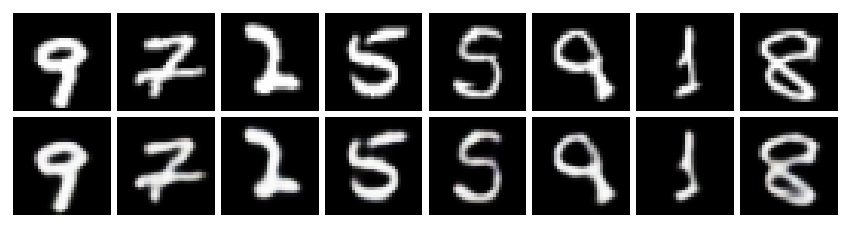

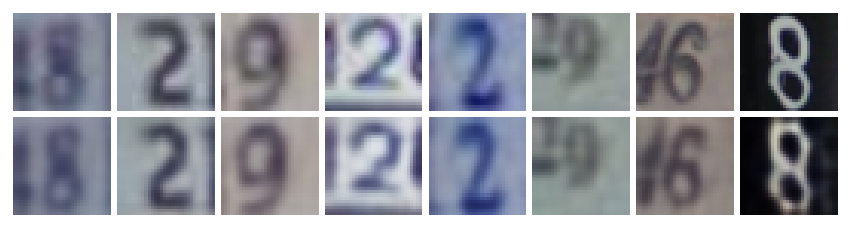

In [ ]:
mnist_test_sample, _ = iter(mnist_test_loader).next()
svhn_test_sample, _ = iter(svhn_test_loader).next()
autoencoder.eval()
with torch.no_grad():
    mnist_test_decoded = autoencoder(mnist_test_sample.to(device))
    svhn_test_decoded = autoencoder(svhn_test_sample.to(device))

mnist_imgs = make_grid(
    torch.cat((mnist_test_sample.to(device), mnist_test_decoded.to(device))), scale_each=True, pad_value=1
)
svhn_imgs = make_grid(
    torch.cat((svhn_test_sample.to(device), svhn_test_decoded.to(device))), scale_each=True, pad_value=1
)


plt.figure(figsize=(15, 30))
plt.imshow(toPIL(mnist_imgs))
plt.axis("off")
plt.figure(figsize=(15, 30))
plt.imshow(toPIL(svhn_imgs))
plt.axis("off")

As seen the autoencoder network can reconstruct the SVHN images (3rd row original image, 4th row reconstructed image). Additionally, even though it wasn't trained using the MNIST dataset it was still able to reconstruct it (1st row original image, 2nd row reconstructed image). 

## Arbitrary Style Transfer

The paper in [\[3\]](#3) presented an arbitrary style transfer that utilizes adaptive instance normalization. Given a content and style images. The network transfers the style of the style images to the content images without lossing the structure of the content image. Their algorithm were able to transfer any style with a minimal amount of time. Their algorithm utilizes an adaptive instance layer to perform the style transfer.

### Adaptive Instance Normalization

Adaptive Instance Normalization (AdaIN) takes place in the feature space. It normalizes the styles by normalizing the feature statistics. The feature statistics used for this normalization are the mean and variance. From the name, it implies that the normalization happens per instance. The mean and variance is computed per data per channel. With this, an RGB image will have 3 means and 3 variance - one pair for each channel.

Unlike other normalization algorithms like batch normalization, instance normalization, and conditional instance normalization, adaptive instance normalization doesn't have any learnable parameters. It normalizes the style of the content image by using the mean and variance of the style image.

Let $\boldsymbol{c}$ be the content while $\boldsymbol{s}$ is the style

$$AdaIN(c,y) = \sigma\left(\boldsymbol{s}\right)\left(\frac{\boldsymbol{c} - \mu\left(\boldsymbol{c}\right)}{\sigma\left(\boldsymbol{c}\right)}\right) + \mu\left(\boldsymbol{s}\right)$$

where $\mu$ is the mean of the data while $\sigma$ is the standard deviation of the data.

### Network Architecture

In the paper the architecture uses the pretrained VGG19 model. It uses up until ReLU4_1 layer. The VGG19 network is used as an encoder block. It extracts the features of a given image. Both the content and style images will pass through this network. AdaIN is performed for the two feature maps. The resulting feature map is then fed to a decoder network. The decoder network reconstructs the styled content.

![Network Architecture](figures/network.jpg)

### Loss Functions

Two losses are considered for this network, the content and style loss. The content loss is the loss between the feature map after the AdaIN layer and the feature map of the encoded styled content. For the style loss, the difference between the mean and variances of the feature maps of the style image and styled content are computed. The means and variances are derived from various layers of the decoder network. Both losses uses MSE as the loss function.

### Helper Functions

The following functions are used to compute for the AdaIN and losses.

In [ ]:
EPS = 1e-5


def get_mean_std(data):
    assert (
        len(data.shape) == 4
    ), "data must have shape of (batch_size, n_channels, height, width)"

    batch_size, n_channels = data.shape[:2]

    flattened_data = data.view(batch_size, n_channels, -1)
    mean = flattened_data.mean(axis=2).view(batch_size, n_channels, 1, 1)
    variance = (
        (flattened_data.var(axis=2) + EPS).sqrt().view(batch_size, n_channels, 1, 1)
    )
    return mean, variance


def get_content_loss(inputs, targets):
    return F.mse_loss(inputs, targets)


def get_style_loss(inputs, targets):
    inputs_mean, inputs_std = get_mean_std(inputs)
    targets_mean, targets_std = get_mean_std(targets)
    return F.mse_loss(inputs_mean, targets_mean) + F.mse_loss(inputs_std, targets_std)


def adaptive_instance_normalization(content, style):
    content_mean, content_std = get_mean_std(content)
    style_mean, style_std = get_mean_std(style)

    return ((content - content_mean) / content_std) * style_std + style_mean

### Style Transfer Network

Since VGG19 requires the input image to have a resolution of at least $224\times224$ pixels, it won't be feasible for the style transfer involving the MNIST and SVHN datasets. Additionally, the network would be an overkill for these datasets. Instead, a simpler CNN autoencoder network will be used. The encoder network is composed of 5 convolutional layers. The decoder network uses 4 convolutional layers. The networks have 4 maxpools which makes the features map input of the AdaIN layer to have a resolution of $4\times4$ pixels. The decoder network uses upsampling + regular convolutional layers [\[4\]](#4) instead of transposed convolution with stride of 2. In the previous attemps as shown in this [commit](https://github.com/peeeyow/adain-mnist-svhn/blob/efec5570b1dd8c4cea1ddeb5b01c08f78f7ae30a/adain_mnist_svhn.ipynb), a smaller CNN autoencoder was used with the decoder having transposed convolution layers. The resulting style transfer suffered from heavy checkboard artifacts. With this, the CNN autoencoder network was made bigger and the decoder network was changed to use upsampling + convolutional layers instead. 

To fasten the training of the style transfer network. The autoencoder network was first trained on the SVHN dataset. The trained autoencoder network where able to reconstruct both the MNIST dataset and the SVHN dataset. The encoder-decoder network were able to efficiently extract and reconstruct the features of the images.

The weights of the autoencoder network were used for the style transfer network. The encoder weights were freeze while the decoder network was fine tuned for the style transfer.

In [ ]:
class StyleTransfer(nn.Module):
    def __init__(self, encoder=None, decoder=None):
        super(StyleTransfer, self).__init__()
        if encoder is None:

            self.enc_1 = nn.Sequential(
                nn.Conv2d(3, 32, 3, padding="same", padding_mode="reflect"),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # (16, 16)
            )
            self.enc_2 = nn.Sequential(
                nn.Conv2d(32, 64, 3, padding="same", padding_mode="reflect"),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # (8, 8)
            )
            self.enc_3 = nn.Sequential(
                nn.Conv2d(64, 64, 3, padding="same", padding_mode="reflect"),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # (4, 4)
            )
            self.enc_4 = nn.Sequential(
                nn.Conv2d(64, 128, 3, padding="same", padding_mode="reflect"),
                nn.ReLU(),
                nn.Conv2d(128, 128, 3, padding="same", padding_mode="reflect"),
                nn.ReLU(),
            )
        else:
            enc_layers = list(list(encoder.children())[0].children())
            self.enc_1 = nn.Sequential(*enc_layers[:3])
            self.enc_2 = nn.Sequential(*enc_layers[3:6])
            self.enc_3 = nn.Sequential(*enc_layers[6:9])
            self.enc_4 = nn.Sequential(*enc_layers[9:])
        if decoder is None:
            self.decoder = Decoder()
        else:
            self.decoder = decoder

        for idx in range(1, 5):
            for param in getattr(self, f"enc_{idx}").parameters():
                param.requires_grad = False

    def encode_intermediate(self, inputs):
        results = [inputs]
        for idx in range(1, 5):
            func = getattr(self, f"enc_{idx}")
            results.append(func(results[-1]))

        return results[1:]

    def encode(self, x):
        for idx in range(1, 5):
            x = getattr(self, f"enc_{idx}")(x)
        return x

    def forward(self, content, style, alpha=1.0):
        assert 0 <= alpha <= 1.0, "alpha must be from 0 to 1"

        encoded_content = self.encode(content)
        encoded_style = self.encode_intermediate(style)

        latent_styled_content = (
            alpha * adaptive_instance_normalization(encoded_content, encoded_style[-1])
            + (1 - alpha) * encoded_content
        )

        styled_content = self.decoder(latent_styled_content)

        if not self.training:
            return styled_content

        encoded_styled_content = self.encode_intermediate(styled_content)

        content_loss = get_content_loss(
            latent_styled_content, encoded_styled_content[-1]
        )
        style_loss = 0
        for st, est in zip(encoded_style, encoded_styled_content):
            style_loss += get_style_loss(st, est)

        return content_loss, style_loss

### Plot Styled Contents

In [ ]:
def plot_sample():
    mnist_test_sample, _ = iter(mnist_test_loader).next()
    svhn_test_sample, _ = iter(svhn_test_loader).next()
    style_transfer.eval()
    with torch.no_grad():
        styled_contents = style_transfer(mnist_test_sample.to(device), svhn_test_sample.to(device))

    imgs = torch.empty((8*3, 3, 32, 32))

    for idx in range(8):
        imgs[idx*3] = mnist_test_sample[idx]
        imgs[idx*3+1] = svhn_test_sample[idx]
        imgs[idx*3+2] = styled_contents[idx]

    imgs = make_grid(imgs, nrow=3, scale_each=True, pad_value=1)

    plt.figure(figsize=(8*5, 3*5))
    plt.imshow(toPIL(imgs))
    plt.axis("off")
    plt.show()

### Style Transfer Network Trainer

In [ ]:
def train_one_epoch(
    model,
    device,
    content_loader,
    style_loader,
    gamma,
    optimizer,
    scheduler,
    curr_epoch,
    tot_epochs,
    best_loss,
    writer,
):
    losses = []
    with tqdm(
        enumerate(zip(content_loader, style_loader)), total=len(content_loader)
    ) as loop:
        for n_iter, (contents, styles) in loop:
            optimizer.zero_grad()

            content = contents[0].to(device)
            style = styles[0].to(device)

            model.train()
            content_loss, style_loss = model(content, style)

            total_loss = content_loss + gamma * style_loss

            total_loss.backward()

            optimizer.step()
            scheduler.step()

            losses.append(total_loss.item())

            loop.set_description(f"Epoch [{curr_epoch+1}/{tot_epochs}]")
            loop.set_postfix(
                loss=losses[-1],
            )

            writer.add_scalars(
                "Training Loss",
                {
                    "loss_style": style_loss.item(),
                    "loss_content": content_loss.item(),
                },
                curr_epoch * len(content_loader) + n_iter,
            )
            writer.flush()

            if losses[-1] < best_loss:
                best_loss = losses[-1]
                model_path = Path(
                    "models/model_{}_{}".format(
                        TIME_STAMP, curr_epoch * len(content_loader) + n_iter
                    )
                )
                torch.save(model.state_dict(), model_path)

            if (curr_epoch * len(content_loader) + n_iter) % 1000 == 0:
                plot_sample()

    return np.mean(losses), best_loss


def fit(
    model,
    device,
    content_loader,
    style_loader,
    gamma,
    optimizer,
    scheduler,
    epochs,
    writer,
):

    Path("models").mkdir(parents=True, exist_ok=True)
    best_loss = float("inf")
    for epoch in range(epochs):
        _, best_loss = train_one_epoch(
            model,
            device,
            content_loader,
            style_loader,
            gamma,
            optimizer,
            scheduler,
            epoch,
            epochs,
            best_loss,
            writer,
        )
        plot_sample()

### Building Model

In [ ]:
style_transfer = StyleTransfer(
    copy.deepcopy(autoencoder.encoder),
    copy.deepcopy(autoencoder.decoder),
).to(device)

### Hyperparameters

The `gamma` variable is used as the weight of the style loss. Various combinations of the learning rate and gamma were used. The batch size was fixed to 8, the paper also used 8 as batch size. The epoch was set to 10 but it is a misrepresentation of the use of epochs. For each epoch the train datasets for both the MNIST and SVHN datasets are shuffled and paired. Repetition of pairing may occur but it is very unlikely. Which means that the network isn't trained for the same data for each epoch. Instead, the network was trained for 75000 iteration of potentially unique pairings of the MNIST and SVHN datasets.

In [ ]:
TIME_STAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter(f"runs/{TIME_STAMP}")

# gamma = 5
gamma = 10

init_lr = 1e-5
optimizer = Adam(style_transfer.parameters(), lr=init_lr)
update = lambda x: 1 / (1.0 + 1e-5 * x)
scheduler = LambdaLR(optimizer, lr_lambda=update)

epochs = 10

### Style Transfer Network Training

In [ ]:
weight_path = Path("style_weights")
if weight_path.is_file():
    style_transfer.load_state_dict(torch.load(weight_path, map_location=device))
else:
    fit(
        style_transfer,
        device,
        mnist_train_loader,
        svhn_train_loader,
        gamma,
        optimizer,
        scheduler,
        epochs,
        writer,
    )

### Network Training Loss

![Style Transfer Loss](figures/style_network_loss.png)

### Example Style Transfer

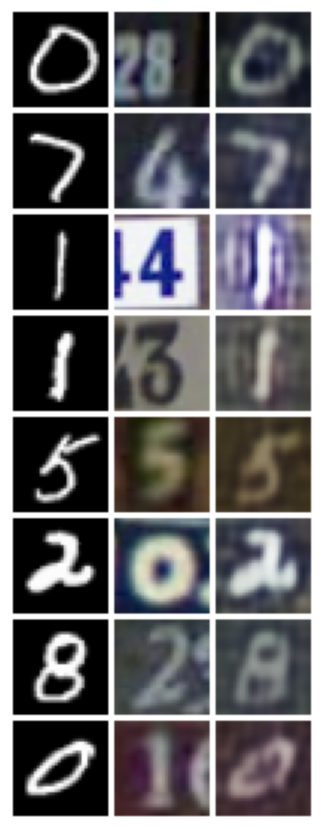

In [ ]:
plot_sample()

As seen, the network was able to transfer the sytle of the SVHN dataset to the MNIST dataset. Also note that the images presented above was never been seen by the network. The network was able to adaptively apply the styles of the SVHN dataset to the MNIST dataset. The structure of the MNIST digits was never been loss while its style were able to change base on the applied SVHN image.

## References

<a id='1'>[\[1\] 
L. Deng, “The mnist database of handwritten digit images for machine learning research”, IEEE Signal Processing Magazine, vol 29, no 6, bll 141–142, 2012.](http://yann.lecun.com/exdb/mnist/)</a>  
<a id='2'>[\[2\] Y. Netzer, T. Wang, A. Coates, R. Bissacco, B. Wu, en A. Y. Ng, “Reading Digits in Natural Images with Unsupervised Feature Learning”.](http://ufldl.stanford.edu/housenumbers/)</a>  
<a id='3'>[\[3\] X. Huang en S. Belongie, “Arbitrary style transfer in real-time with adaptive instance normalization”, in Proceedings of the IEEE International Conference on Computer Vision, 2017, bll 1501–1510.](https://arxiv.org/abs/1703.06868)</a>  
<a id='4'>[\[4\] naoto0804, “pytorch-AdaIN”, GitHub repository. GitHub, 2021.](https://github.com/naoto0804/pytorch-AdaIN)</a>  


## Misc

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
drive.flush_and_unmount()

#### Mixed

In [ ]:
mix_dataset_train = ConcatDataset([mnist_train, svhn_train])
train_dataloader = DataLoader(mix_dataset_train, batch_size=256, shuffle=True, num_workers=2)
mix_dataset_test = ConcatDataset([mnist_test, svhn_test])
test_dataloader = DataLoader(mix_dataset_test, batch_size=256, shuffle=True, num_workers=2)


In [ ]:
mnist_test_sample, _ = iter(mnist_test_loader).next()
svhn_test_sample, _ = iter(svhn_test_loader).next()

style_transfer.train()
print("train")
print(len(style_transfer(mnist_test_sample, svhn_test_sample)))
style_transfer.eval()
print("eval")
print(style_transfer(mnist_test_sample, svhn_test_sample))